In [2]:
%pip install pandas matplotlib seaborn scikit-learn joblib


Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import joblib
import numpy as np


In [4]:
# Load the data
train_data = pd.read_csv('fraudTrain.csv')
test_data = pd.read_csv('fraudTest.csv')

# Display the first few rows of the training data
train_data.head()


,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


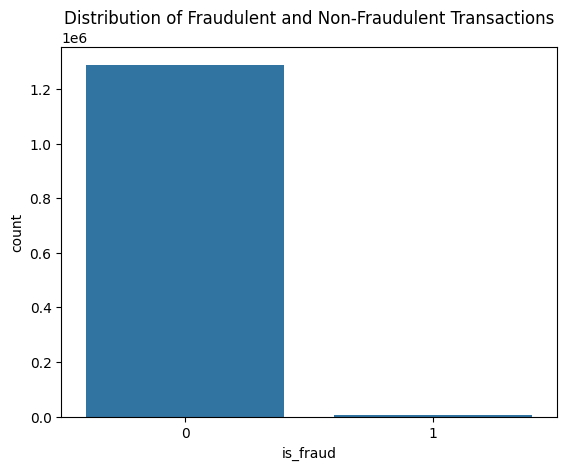

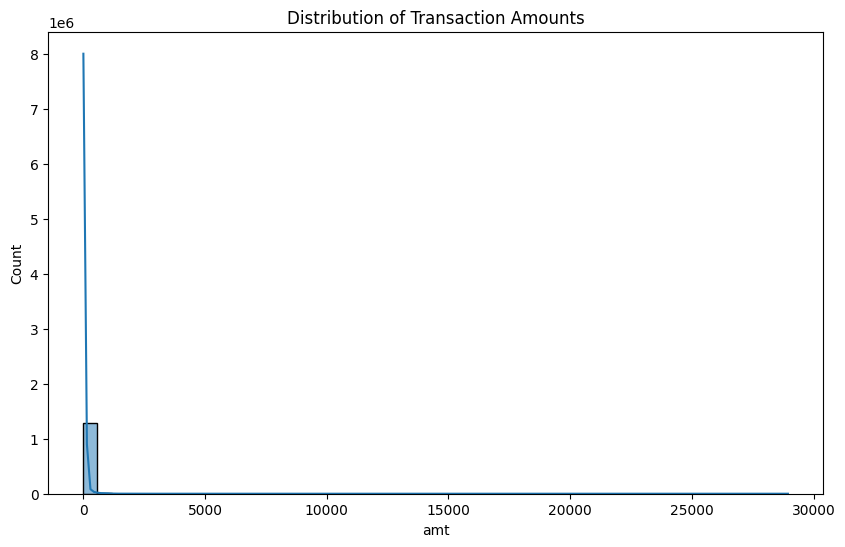

In [5]:
# Distribution of the target variable
sns.countplot(x='is_fraud', data=train_data)
plt.title('Distribution of Fraudulent and Non-Fraudulent Transactions')
plt.show()

# Distribution of transaction amounts
plt.figure(figsize=(10, 6))
sns.histplot(train_data['amt'], bins=50, kde=True)
plt.title('Distribution of Transaction Amounts')
plt.show()


In [18]:
# Cell 5: Data Preprocessing
# Handle missing values
train_data = train_data.dropna()
test_data = test_data.dropna()

# Combine train and test data for encoding
combined_data = pd.concat([train_data, test_data], ignore_index=True)

# Ensure categorical columns are of type string
categorical_columns = ['category', 'gender', 'state', 'job']
for col in categorical_columns:
    combined_data[col] = combined_data[col].astype(str)

# Encode categorical variables
label_encoder = LabelEncoder()
for col in categorical_columns:
    combined_data[col] = label_encoder.fit_transform(combined_data[col])

# Split the combined data back into train and test sets
train_data[categorical_columns] = combined_data[categorical_columns].iloc[:train_data.shape[0]].values
test_data[categorical_columns] = combined_data[categorical_columns].iloc[train_data.shape[0]:].values

# Scale numerical features
scaler = StandardScaler()
numerical_columns = ['amt', 'lat', 'long', 'city_pop', 'unix_time', 'merch_lat', 'merch_long']

train_data[numerical_columns] = scaler.fit_transform(train_data[numerical_columns])
test_data[numerical_columns] = scaler.transform(test_data[numerical_columns])

# Define features and target
X_train = train_data.drop(columns=['is_fraud', 'trans_date_trans_time', 'cc_num', 'first', 'last', 'street', 'city', 'dob', 'trans_num'])
y_train = train_data['is_fraud']

X_test = test_data.drop(columns=['is_fraud', 'trans_date_trans_time', 'cc_num', 'first', 'last', 'street', 'city', 'dob', 'trans_num'])
y_test = test_data['is_fraud']


In [19]:
# Cell 6: Verify and Clean Data

# Convert X_train and X_test to numeric if not already
X_train_numeric = X_train.apply(pd.to_numeric, errors='coerce')
X_test_numeric = X_test.apply(pd.to_numeric, errors='coerce')

# Check for infinite values
print("Infinite values in X_train:", np.isinf(X_train_numeric).sum().sum())
print("Infinite values in X_test:", np.isinf(X_test_numeric).sum().sum())

# Check for NaN values
print("NaN values in X_train:", X_train_numeric.isna().sum().sum())
print("NaN values in X_test:", X_test_numeric.isna().sum().sum())

# If there are NaN or infinite values, handle them
# For this example, we replace NaN and infinite values with 0
X_train_numeric = X_train_numeric.fillna(0).replace([np.inf, -np.inf], 0)
X_test_numeric = X_test_numeric.fillna(0).replace([np.inf, -np.inf], 0)

# Ensure `y_train` is numeric and has no NaN values
print("NaN values in y_train:", y_train.isna().sum())


Infinite values in X_train: 0
Infinite values in X_test: 0
NaN values in X_train: 1296675
NaN values in X_test: 555719
NaN values in y_train: 0


Logistic Regression:


d:\python3.8\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\python3.8\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\python3.8\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.00      0.00      0.00      2145

    accuracy                           1.00    555719
   macro avg       0.50      0.50      0.50    555719
weighted avg       0.99      1.00      0.99    555719

Accuracy: 0.9961401355721147


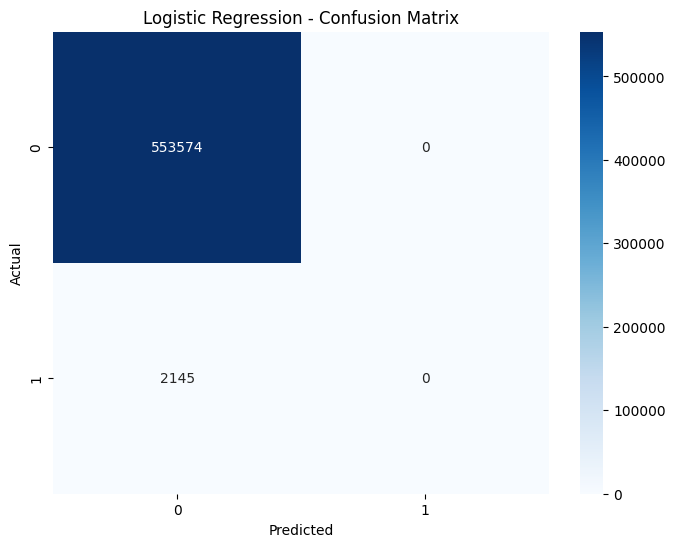

In [20]:
# Cell 7: Train and Evaluate Logistic Regression

# Train the model
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_numeric, y_train)

# Predict on the test set
y_pred_logreg = logreg.predict(X_test_numeric)

# Evaluate the model
print("Logistic Regression:")
print(classification_report(y_test, y_pred_logreg))
print("Accuracy:", accuracy_score(y_test, y_pred_logreg))

# Confusion matrix
conf_matrix_logreg = confusion_matrix(y_test, y_pred_logreg)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_logreg, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Logistic Regression - Confusion Matrix')
plt.show()


Decision Tree:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    553574
           1       0.10      0.56      0.18      2145

    accuracy                           0.98    555719
   macro avg       0.55      0.77      0.58    555719
weighted avg       0.99      0.98      0.99    555719

Accuracy: 0.9797757499743576


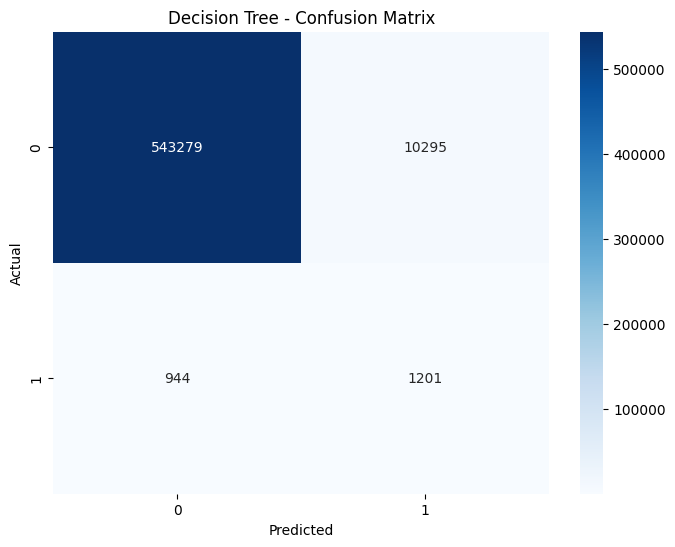

In [21]:
# Cell 8: Train and Evaluate Decision Tree

# Train the model
tree = DecisionTreeClassifier()
tree.fit(X_train_numeric, y_train)

# Predict on the test set
y_pred_tree = tree.predict(X_test_numeric)

# Evaluate the model
print("Decision Tree:")
print(classification_report(y_test, y_pred_tree))
print("Accuracy:", accuracy_score(y_test, y_pred_tree))

# Confusion matrix
conf_matrix_tree = confusion_matrix(y_test, y_pred_tree)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_tree, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Decision Tree - Confusion Matrix')
plt.show()


Random Forest:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.82      0.41      0.55      2145

    accuracy                           1.00    555719
   macro avg       0.91      0.70      0.77    555719
weighted avg       1.00      1.00      1.00    555719

Accuracy: 0.9973799708125869


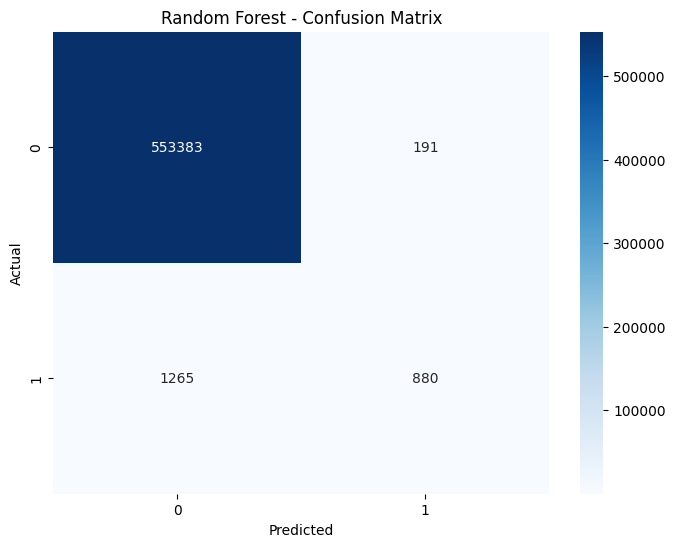

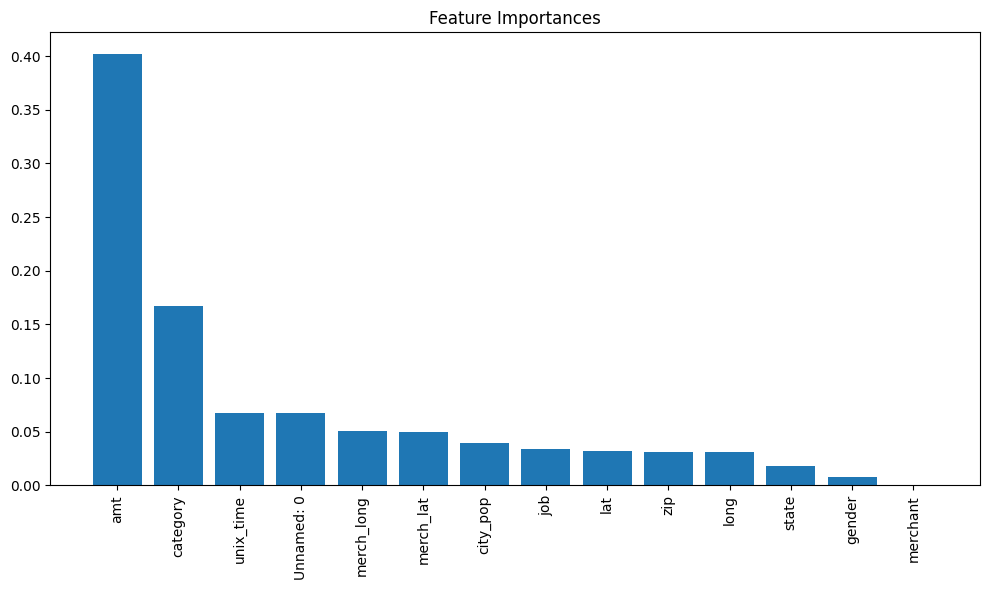

In [22]:
# Cell 9: Train and Evaluate Random Forest

# Train the model
forest = RandomForestClassifier()
forest.fit(X_train_numeric, y_train)

# Predict on the test set
y_pred_forest = forest.predict(X_test_numeric)

# Evaluate the model
print("Random Forest:")
print(classification_report(y_test, y_pred_forest))
print("Accuracy:", accuracy_score(y_test, y_pred_forest))

# Confusion matrix
conf_matrix_forest = confusion_matrix(y_test, y_pred_forest)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_forest, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest - Confusion Matrix')
plt.show()

# Feature importance
importances = forest.feature_importances_
features = X_train.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]), importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), features[indices], rotation=90)
plt.tight_layout()
plt.show()


In [24]:
# Cell 10: Compare Models

# Add predictions to the test data for each model
test_data['logreg_pred'] = y_pred_logreg
test_data['tree_pred'] = y_pred_tree
test_data['forest_pred'] = y_pred_forest

# Review a few rows with predictions
test_data[['trans_date_trans_time', 'cc_num', 'amt', 'is_fraud', 'logreg_pred', 'tree_pred', 'forest_pred']].head(100)


,trans_date_trans_time,cc_num,amt,is_fraud,logreg_pred,tree_pred,forest_pred
0,2020-06-21 12:14:25,2291163933867244,-0.420988,0,0,0,0
1,2020-06-21 12:14:33,3573030041201292,-0.252695,0,0,0,0
2,2020-06-21 12:14:53,3598215285024754,-0.181336,0,0,0,0
3,2020-06-21 12:15:15,3591919803438423,-0.064255,0,0,0,0
4,2020-06-21 12:15:17,3526826139003047,-0.418929,0,0,1,0
...,...,...,...,...,...,...,...
95,2020-06-21 12:43:14,6011438889172900,-0.207160,0,0,0,0
96,2020-06-21 12:43:58,5501083170975659,-0.338650,0,0,0,0
97,2020-06-21 12:44:12,6011104316292105,-0.432527,0,0,0,0
98,2020-06-21 12:44:29,374930071163758,-0.395288,0,0,0,0


In [25]:
# Cell 11: Save the Best Model (Random Forest)

# Save the model
joblib.dump(forest, 'fraud_detection_model.pkl')


['fraud_detection_model.pkl']

In [26]:
# Cell 12: Load the Model and Make Predictions

# Load the model
model = joblib.load('fraud_detection_model.pkl')

# Predict on new data
new_data = X_test_numeric.iloc[0].values.reshape(1, -1)
prediction = model.predict(new_data)
print(f'Predicted class: {prediction[0]}')


Predicted class: 0


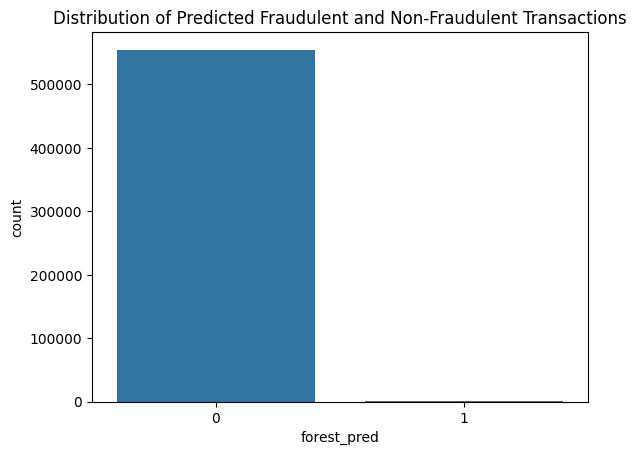

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,logreg_pred,tree_pred,forest_pred
1767,1767,2020-06-21 22:32:22,6564459919350820,"fraud_Rodriguez, Yost and Jenkins",4,4.429808,Douglas,Willis,1,619 Jeremy Garden Apt. 681,...,847,1958-09-10,ab4b379d2c0c9c667d46508d4e126d72,1.760753,0.767897,-0.066856,1,0,1,1
1857,1857,2020-06-21 23:02:16,3560725013359375,fraud_Hermann and Sons,8,4.817355,Brooke,Smith,0,63542 Luna Brook Apt. 012,...,561,1969-09-15,f6838c01f5d2262006e6b71d33ba7c6d,1.760892,-1.413279,-0.908420,1,0,0,1
2026,2026,2020-06-21 23:59:05,6564459919350820,fraud_Lemke-Gutmann,7,5.519156,Douglas,Willis,1,619 Jeremy Garden Apt. 681,...,847,1958-09-10,1799ffe421a2a05dc87903e379140f55,1.761158,0.878812,-0.019410,1,0,0,1
2195,2195,2020-06-22 01:25:13,4005676619255478,"fraud_Goldner, Kovacek and Abbott",12,1.600520,William,Perry,1,458 Phillips Island Apt. 768,...,677,1994-05-31,219c46c355f98b732d9a36818c5b8a88,1.761560,-1.712937,-0.032345,1,0,1,1
2258,2258,2020-06-22 01:54:33,3524574586339330,"fraud_Osinski, Ledner and Leuschke",12,1.763573,Ashley,Cabrera,0,94225 Smith Springs Apt. 617,...,727,1986-05-07,7220be6f2a92f9c1056d2bcf46c986bd,1.761697,-2.012045,0.676193,1,0,1,1
6260,6260,2020-06-23 01:20:25,6517217825320610,"fraud_Douglas, Schneider and Turner",8,4.830828,James,Reese,1,26975 Richardson Mills Apt. 402,...,726,1958-06-11,60c3651f49217f0ff92f033015a6b0e4,1.768266,-1.504506,0.011572,0,0,0,1
6539,6539,2020-06-23 03:30:22,30376238035123,fraud_Fisher-Schowalter,7,6.323630,Cynthia,Davis,0,7177 Steven Forges,...,870,1928-10-01,5966d1dd8a3b27a3ca51e2e83f39d7da,1.768873,0.844502,-2.483846,0,0,0,1
7269,7269,2020-06-23 09:08:00,4839615922685395,"fraud_Romaguera, Cruickshank and Greenholt",7,5.854619,Phillip,Robertson,1,85344 Smith Gateway Apt. 280,...,895,1955-05-06,051bf0b7d4ed100f952d7cca0bb121ed,1.770451,0.249969,0.278787,0,0,1,1
10036,10036,2020-06-24 00:26:45,180098888332620,fraud_DuBuque LLC,12,1.528849,Dennis,Davidson,1,08469 Trujillo Forge,...,883,1959-03-30,6337ebf236753a68a2697295960a30b7,1.774744,0.753116,0.813497,1,0,1,1
10047,10047,2020-06-24 00:44:24,180098888332620,"fraud_Huel, Hammes and Witting",12,1.306351,Dennis,Davidson,1,08469 Trujillo Forge,...,883,1959-03-30,193eebbe720a3f04ab49e04ec2355902,1.774826,0.657712,0.858935,1,0,1,1


In [27]:
# Cell 13: Visualize Predicted Fraudulent Transactions

# Distribution of Predicted Fraudulent Transactions
sns.countplot(x='forest_pred', data=test_data)
plt.title('Distribution of Predicted Fraudulent and Non-Fraudulent Transactions')
plt.show()

# Review predicted fraudulent transactions
predicted_fraud = test_data[test_data['forest_pred'] == 1]
predicted_fraud.head(10)
